# ISAS CMOS event data QL example

In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import astropy.io.fits as pyfits

plt.rcParams["font.family"]="serif"
plt.rcParams["font.size"]= 10

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    #return arr.reshape(shape).mean(-1).mean(1)
    return arr.reshape(shape).sum(-1).sum(1)

In [2]:
### Set event fits filename here ###
evtfname = '141637.evt'

hdul = pyfits.open(evtfname)
hdu = hdul["EVENTS"]

#vtime = hdu.data.field("TIME")
vclk = hdu.data.field("SEQCLK")
vx = hdu.data.field("X")
vy = hdu.data.field("Y")
vpha = hdu.data.field("PHASUM")
vnhits = hdu.data.field("NHITPIX")
#vflag = hdu.data.field("FLAG")
#vframeid = hdu.data.field("FRAMEID")

### read header keyword
print("TELESCOP = ", hdu.header["TELESCOP"])
print("INSTRUME = ", hdu.header["INSTRUME"])
#print("TIMEDEL  = ", hdu.header["TIMEDEL"])

#timedel = hdu.header["TIMEDEL"]
xpixmin = hdu.header["TLMIN2"]
xpixmax = hdu.header["TLMAX2"]
ypixmin = hdu.header["TLMIN3"]
ypixmax = hdu.header["TLMAX3"]
#phamin  = hdu.header["TLMIN4"]
#phamax  = hdu.header["TLMAX4"]

#print("TIMEDEL =", timedel)
print("Xmin, Xmax = ", xpixmin, xpixmax)
print("Ymin, Ymax = ", ypixmin, ypixmax)
#print("PHAmin, PHAmax = ", phamin, phamax)

hdul.close()

TELESCOP =  HIZGUNDAM
INSTRUME =  EAGLE
Xmin, Xmax =  0 2047
Ymin, Ymax =  0 2047


SEQCLK from 1014745 to 1036241 (21496)
nbin=512, binsize=42, xmi, xma = -0.50, 21503.50


Text(0.5, 1.0, 'Event rate')

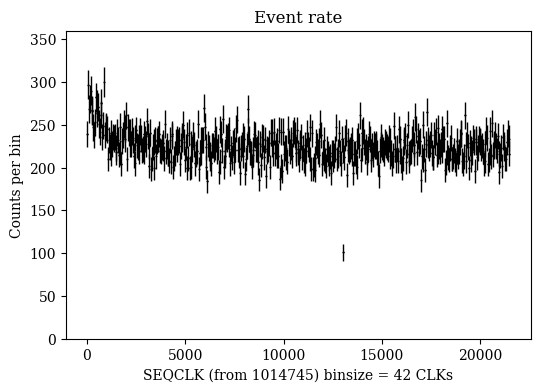

In [3]:
### Event counts per frame ####
fig1, ax1 = plt.subplots(figsize=(6,4))

clkmi = vclk[0]
clkma = vclk[-1]
print("SEQCLK from %d to %d (%d)"%(clkmi, clkma, clkma-clkmi))

#nbin = 500
#binsize = int(float(clkma -clkmi)/nbin)
binsize = 42
nbin = int(np.ceil((clkma -clkmi)/binsize))
xmi = -0.5
xma = xmi + nbin*binsize
print("nbin=%d, binsize=%d, xmi, xma = %.2lf, %.2lf"%(nbin, binsize, xmi, xma))

hist_frmcts, xedges   = np.histogram(vclk-clkmi, nbin, range=(xmi, xma))
vxcen = (xedges[:-1] + xedges[1:])/2.
vxwid = (xedges[1:] - xedges[:-1])/2.
hister_frmcts = np.sqrt(hist_frmcts)

ax1.errorbar(vxcen, hist_frmcts, xerr=vxwid, yerr=hister_frmcts, fmt='.', ms=1, lw=1, color='k')
ymax = hist_frmcts.max()*1.2
ax1.set_ylim(0.0, ymax)

ax1.set_xlabel('SEQCLK (from %d) binsize = %d CLKs'%(clkmi, binsize))
ax1.set_ylabel('Counts per bin')
ax1.set_title('Event rate')

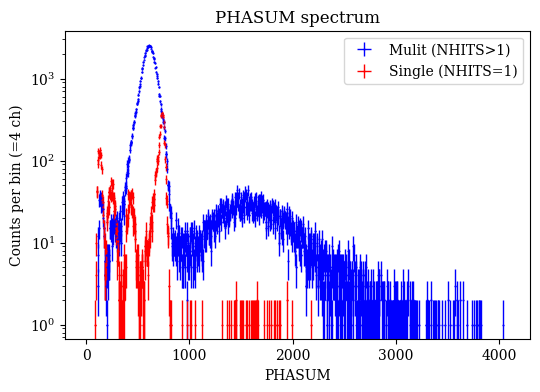

In [4]:
### PHACSUM specturm
fig2, ax2 = plt.subplots(figsize=(6,4))
binsize = 4
nbin = int(4096/binsize)
xmi = -0.5
xma = 4096-0.5
#nbin = int((phamax-phamin+1)/binsize)
#xmi = adumin-0.5
#xma = adumax+0.5

hist_pha1, xedges = np.histogram(vpha[vnhits>1], nbin, range=(xmi, xma))
hist_pha2, xedges = np.histogram(vpha[vnhits==1], nbin, range=(xmi, xma))
vxcen = (xedges[:-1] + xedges[1:])/2.
vxwid = (xedges[1:] - xedges[:-1])/2.
hister_pha1 = np.sqrt(hist_pha1)
hister_pha2 = np.sqrt(hist_pha2) 
ax2.errorbar(vxcen, hist_pha1, xerr=vxwid, yerr=hister_pha1, fmt='.', ms=1, lw=1, color='b', label='Mulit (NHITS>1)')
ax2.errorbar(vxcen, hist_pha2, xerr=vxwid, yerr=hister_pha2, fmt='.', ms=1, lw=1, color='r', label='Single (NHITS=1)')
ax2.set_xlabel('PHASUM')
ax2.set_ylabel('Counts per bin (=%d ch)'%(binsize))
ax2.set_title('PHASUM spectrum')     
ax2.set_yscale('log')
ax2.legend()

Image min=0, max=1023, mean=0.027468
Bad pixels =
 [[ 176  732]
 [ 530 1921]
 [ 615 1405]
 [ 645 1472]
 [1232 1707]
 [1651 1882]]


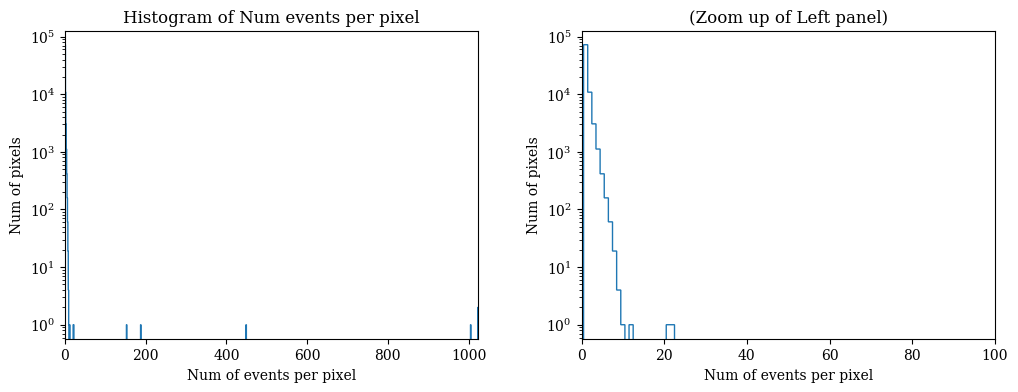

In [5]:
### check hit-count histogram and bad pixel
nxpix = xpixmax-xpixmin+1
nypix = ypixmax-ypixmin+1
xmima = (xpixmin-0.5, xpixmax+0.5)
ymima = (ypixmin-0.5, ypixmax+0.5)


hist2d, xedges, yedges = np.histogram2d(vx, vy, bins=(nxpix, nypix), range=(xmima, ymima))

print("Image min=%d, max=%d, mean=%lf"%(hist2d.min(), hist2d.max(), hist2d.mean()))
#hmin = -0.5
hmin = 0.5
hmax = hist2d.max() + 0.5
nbins = int(hmax-hmin)
histhits, hedges = np.histogram(hist2d, bins=nbins, range=(hmin, hmax))

fig3a, ax3a = plt.subplots(1,2, figsize=(12,4))
fig3a.subplots_adjust(wspace=0.25)

#### plot hist
#ax3[0].plot(hedges)
ax3a[0].stairs(histhits, hedges)
ax3a[0].set_yscale('log')
ax3a[0].set_xlim(0.0, hmax)

ax3a[1].stairs(histhits, hedges)
ax3a[1].set_yscale('log')
ax3a[1].set_xlim(0.0, 100.)

ax3a[0].set_title('Histogram of Num events per pixel')
ax3a[0].set_ylabel('Num of pixels')
ax3a[0].set_xlabel('Num of events per pixel')

ax3a[1].set_title('(Zoom up of Left panel)')
ax3a[1].set_ylabel('Num of pixels')
ax3a[1].set_xlabel('Num of events per pixel')
#fig3a.set_title('PHASUM spectrum')    


### bad pixel threshold = 100
badthr = 100
#print(hist2d>badthr))
badpixels = np.transpose((hist2d>badthr).nonzero())
print("Bad pixels =\n", badpixels)  

Text(0.5, 0.95, 'Image (log scale)')

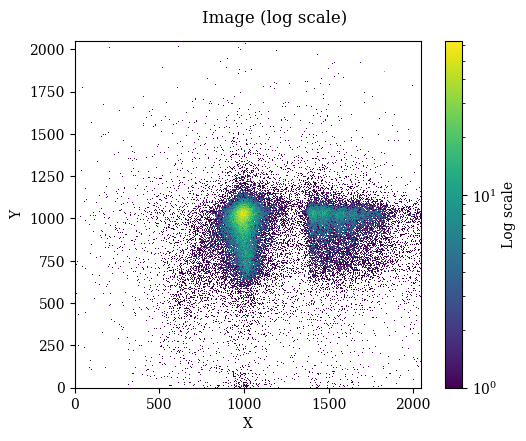

In [6]:
###  XY image (Mask bad pixes, Rebin, log scale) 
fig3b, ax3b = plt.subplots(figsize=(6, 4.5))
hist2d_cl = hist2d * (hist2d<=badthr)  # mask bad pixels
#hist2d_cl = hist2d_cl.T
#hist2d = hist2d.T

#binsize = 1
binsize = 4
nbinx = nxpix//binsize
nbiny = nypix//binsize
hist2d_rebin = rebin(hist2d_cl, (nbinx,nbiny))
im = ax3b.imshow(hist2d_rebin.T, interpolation='nearest', origin='lower',
                 norm=colors.LogNorm(),
                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax3b.set_xlabel("X")
ax3b.set_ylabel("Y")
cb3 = fig3b.colorbar(im, ax=ax3b, label='Log scale') 
fig3b.suptitle('Image (log scale)', y=0.95)

Text(1.05, -1.8, 'Linear scale')

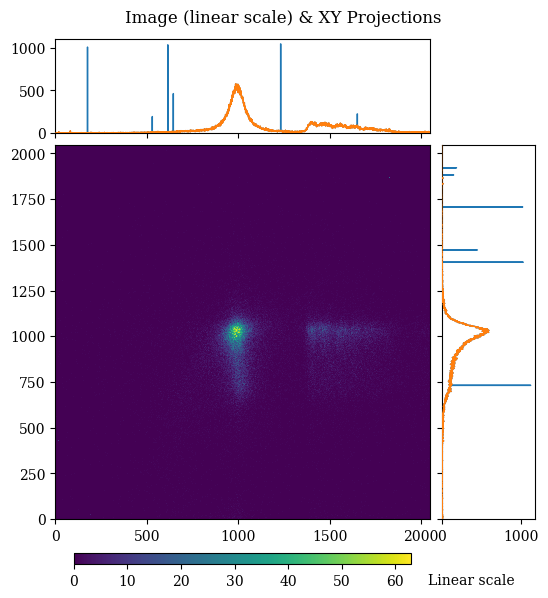

In [7]:
###  XY image and Projections
fig4 = plt.figure(figsize=(6,6)) # , layout="constrained")
gs = fig4.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                       left=0.12, right=0.92, bottom=0.12, top=0.92,
                       wspace=0.05, hspace=0.05)

ax4 = fig4.add_subplot(gs[1, 0])
ax4_histx = fig4.add_subplot(gs[0, 0], sharex=ax4)
ax4_histy = fig4.add_subplot(gs[1, 1], sharey=ax4)
ax4_histx.tick_params(axis="x", labelbottom=False)
ax4_histy.tick_params(axis="y", labelleft=False)

#im2 = ax4.imshow(hist2d_cl.T, interpolation='nearest', origin='lower',
im2 = ax4.imshow(hist2d_rebin.T, interpolation='nearest', origin='lower',
                 #norm=colors.LogNorm(),
                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


ax4_histx.hist(vx, xedges, histtype='step', color='C0', zorder=0) 
ax4_histy.hist(vy, xedges, histtype='step', orientation='horizontal', color='C0', zorder=0) 

hist_prox = rebin(hist2d_cl, (nypix, 1)).transpose()[0]
hist_proy = rebin(hist2d_cl, (1, nxpix))[0]

ax4_histx.stairs(hist_prox, yedges, color='C1', zorder=10)
ax4_histy.stairs(hist_proy, xedges, orientation='horizontal', color='C1', zorder=10)



ax4_histx.stairs(hist_prox, yedges, color='C1')

fig4.suptitle('Image (linear scale) & XY Projections', y=0.97)
cax4 = ax4.inset_axes([0.05, -0.12, 0.9, 0.03])
cb4 = fig4.colorbar(im2, cax=cax4, orientation='horizontal')
cax4.text(1.05, -1.8, "Linear scale", transform=cax4.transAxes)